# Reproduce Transformer Base Model from Attention is All You Need

## Preliminaries

In [5]:
import os, torch, gc


NUM_PROC = os.cpu_count()
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
VOCAB_SIZE = 37000
DATASET = "wmt14"
LANG = "de-en"
SOURCE_LANG = "de"
TARGET_LANG = "en"
MAX_SEQ_LEN = 128
BATCH_SIZE = 64
TRAIN_PERCENTAGE = 1


print("Number of processors: ", NUM_PROC)
print("Device: ", DEVICE)

Number of processors:  32
Device:  cuda


## Dataset

The paper used the dataset [WMT2014](https://huggingface.co/datasets/wmt14) English-German dataset consisting of 4.5M sentence pairs. 

In [6]:
from datasets import load_dataset, disable_caching


disable_caching() # avoid disk explosion
# Note: the dataset is downloaded at ~/.cache/huggingface/datasets
dataset = {
    "train": load_dataset(DATASET, LANG, split=f"train[:{TRAIN_PERCENTAGE}%]"),
    "validation": load_dataset(DATASET, LANG, split="validation"),
    "test": load_dataset(DATASET, LANG, split="test")
}

In [7]:
def probe_dataset():
    # probe the dataset
    for key in dataset:
        print(f"{key}: {len(dataset[key])} entries")
    # print the first 3 entries of the training set
    for i in range(3):
        print(f"#{i+1}")
        sample = dataset["train"][i]
        for key in sample:
            if key == "translation":
                for lang in sample[key]:
                    print(f"{lang}: {sample[key][lang]}")
            else:
                print(f"{key}: {sample[key]}")

    
probe_dataset()

train: 45088 entries
validation: 3000 entries
test: 3003 entries
#1
de: Wiederaufnahme der Sitzungsperiode
en: Resumption of the session
#2
de: Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.
en: I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.
#3
de: Wie Sie feststellen konnten, ist der gefürchtete "Millenium-Bug " nicht eingetreten. Doch sind Bürger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden.
en: Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.


### Tokenizer

The paper used a byte-pair encoding with a shared (English + German) vocab of 37000 tokens. 

I want to build the tokenizer solely from this dataset. So I avoid using pre-trained tokenizer from HuggingFace.

The following code follows [HuggingFace's tutorial on tokenizers](https://huggingface.co/docs/tokenizers/quicktour) .

Training about 2 mins.

In [8]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace


def batch_iterator(batch_size: int = 100):
    for lang in [SOURCE_LANG, TARGET_LANG]:
        for key in ["train", "validation", "test"]:
            for i in range(0, len(dataset[key]), batch_size):
                yield [item[lang] for item in dataset[key][i:i+batch_size]["translation"]]


saved_tokenizer = f"tokenizer-{DATASET}-{SOURCE_LANG}-{TARGET_LANG}.json"
try:
    tokenizer = Tokenizer.from_file(saved_tokenizer)
except:
    tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
    trainer = BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
    tokenizer.pre_tokenizer = Whitespace()
    tokenizer.train_from_iterator(batch_iterator(), trainer=trainer, length=sum([len(_) for _ in dataset.values()]))
    tokenizer.save(saved_tokenizer)

### Update the dataset with tokens

In [9]:
def encode(sample):
    encoding_src = tokenizer.encode("[CLS]", sample["translation"][SOURCE_LANG])
    encoding_tgt = tokenizer.encode("[CLS]", sample["translation"][TARGET_LANG])
    return ({
        "input_ids": encoding_src.ids,
        "attention_mask": torch.tensor(encoding_src.attention_mask) == 0,
        "labels": encoding_tgt.ids,
        "decoder_attention_mask": torch.tensor(encoding_tgt.attention_mask) == 0,
    })

In [10]:
# Takes 1 min
for key in ["train", "validation", "test"]:
    dataset[key] = dataset[key].map(encode, num_proc=NUM_PROC)
probe_dataset()

Map (num_proc=32):   0%|          | 0/45088 [00:00<?, ? examples/s]

Map (num_proc=32):   0%|          | 0/3000 [00:00<?, ? examples/s]

Map (num_proc=32):   0%|          | 0/3003 [00:00<?, ? examples/s]

train: 45088 entries
validation: 3000 entries
test: 3003 entries
#1
de: Wiederaufnahme der Sitzungsperiode
en: Resumption of the session
input_ids: [1, 28682, 3784, 27639]
attention_mask: [False, False, False, False]
labels: [1, 5064, 30454, 3792, 3780, 10827]
decoder_attention_mask: [False, False, False, False, False, False]
#2
de: Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.
en: I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.
input_ids: [1, 4193, 33340, 3804, 3813, 15961, 16, 3895, 5372, 18, 9212, 18543, 73, 27639, 3880, 4495, 5614, 3877, 4877, 9163, 16, 12849, 4757, 13710, 6130, 20620, 4224, 6950, 9848, 3800, 7569, 16, 4332, 3941, 10821, 8613, 7876, 18]
a

### Analyze Sequence Length

In [ ]:
# Takes about 6 mins
seq_len = {"input_ids": [], "labels": []}
for item in dataset["train"]:
    seq_len["input_ids"].append(len(item["input_ids"]))
    seq_len["labels"].append(len(item["labels"]))

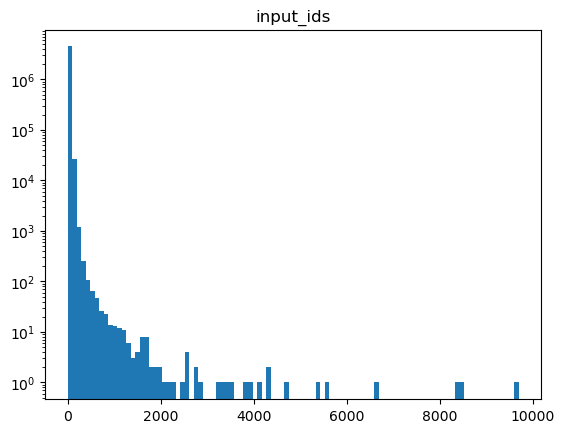

4.2112% of the samples are dropped if truncated at   64 tokens
0.1751% of the samples are dropped if truncated at  128 tokens
0.0189% of the samples are dropped if truncated at  256 tokens
0.0055% of the samples are dropped if truncated at  512 tokens
0.0019% of the samples are dropped if truncated at 1024 tokens
0.0006% of the samples are dropped if truncated at 2048 tokens
0.0002% of the samples are dropped if truncated at 4096 tokens


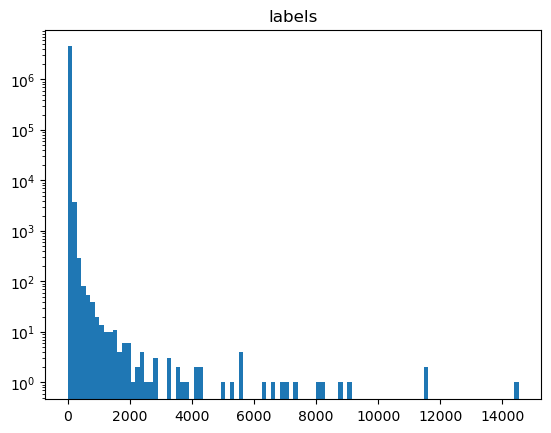

3.9552% of the samples are dropped if truncated at   64 tokens
0.1661% of the samples are dropped if truncated at  128 tokens
0.0175% of the samples are dropped if truncated at  256 tokens
0.0055% of the samples are dropped if truncated at  512 tokens
0.0022% of the samples are dropped if truncated at 1024 tokens
0.0009% of the samples are dropped if truncated at 2048 tokens
0.0005% of the samples are dropped if truncated at 4096 tokens


In [41]:
import numpy as np
import matplotlib.pyplot as plt


for key in seq_len:
    seq_len[key] = np.array(seq_len[key])
    plt.hist(seq_len[key], bins=100, log=True)
    plt.title(key)
    plt.show()
    for exponent in range(6, 13):
        truncate_len = 2 ** exponent
        rate = np.sum(seq_len[key] > truncate_len) / len(seq_len[key])
        print(f"{rate * 100:<6.4f}% of the samples are dropped if truncated at {truncate_len:>4} tokens")

Therefore, during prototyping, I'll use 128 as the max sequence length.

### Reconstruct the dataset with tokens

Takes about 2 mins

In [11]:
tokenizer.enable_padding(pad_id=tokenizer.token_to_id("[PAD]"), pad_token="[PAD]", length=MAX_SEQ_LEN)
tokenizer.enable_truncation(max_length=MAX_SEQ_LEN)
for key in ["train", "validation", "test"]:
    dataset[key] = dataset[key].map(encode, num_proc=NUM_PROC)
probe_dataset()

Map (num_proc=32):   0%|          | 0/45088 [00:00<?, ? examples/s]

Map (num_proc=32):   0%|          | 0/3000 [00:00<?, ? examples/s]

Map (num_proc=32):   0%|          | 0/3003 [00:00<?, ? examples/s]

train: 45088 entries
validation: 3000 entries
test: 3003 entries
#1
de: Wiederaufnahme der Sitzungsperiode
en: Resumption of the session
input_ids: [1, 28682, 3784, 27639, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
attention_mask: [False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

### Create dataloader

In [12]:
dataloader = {}
for key in ["train", "validation", "test"]:
    dataset[key].set_format(type="torch", columns=["input_ids", "attention_mask", "labels", "decoder_attention_mask"])
    dataloader[key] = torch.utils.data.DataLoader(dataset[key], batch_size=BATCH_SIZE, shuffle=True)

In [25]:
for batch in dataloader["validation"]:
    print(batch)
    break

{'input_ids': tensor([[    1, 29297,   185,  ...,     3,     3,     3],
        [    1,  4317,  6747,  ...,     3,     3,     3],
        [    1,     6,  3974,  ...,     3,     3,     3],
        ...,
        [    1,  3974, 26838,  ...,     3,     3,     3],
        [    1,  7881,  3818,  ...,     3,     3,     3],
        [    1,  7134,  4307,  ...,     3,     3,     3]]), 'attention_mask': tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]]), 'labels': tensor([[    1,    57,  3782,  ...,     3,     3,     3],
        [    1,  4181,  3774,  ...,     3,     3,     3],
        [    1,     6, 11178,  ...,     3,     3,     3],
        ...,
        [    1,  3887,  7142,  ...,     3,   

## Transformer from PyTorch

In [14]:
from torch import nn


def pos_encoding(seq_len: int, d_model: int):
    pos = torch.arange(0, seq_len)[None, :, None]
    idx = torch.arange(0, d_model)[None, None, :]
    wavlen = 10000 ** (idx / d_model)
    return torch.sin(pos / wavlen) * (1 - idx % 2) + torch.cos(pos / wavlen) * (idx % 2)


class InverseEmbedding(nn.Module):
    def __init__(self, embedding: nn.Embedding):
        super().__init__()
        self.embedding = embedding
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x: torch.Tensor):
        # x: (batch_size, seq_len, d_model)
        return x @ self.embedding.weight.data.T


class Transformer(nn.Module):
    def __init__(self, d_model: int = 512, nhead: int = 8, num_encoder_layers: int = 6, num_decoder_layers: int = 6,
                 dim_feedforward: int = 2048, dropout: int = 0.1):
        super().__init__()
        # hyperparameters
        self.d_model = d_model
        self.nhead = nhead
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.dim_feedforward = dim_feedforward
        self.dropout = dropout
        # embedding layer
        self.embedding = nn.Embedding(VOCAB_SIZE, d_model)
        self.inverse_embedding = InverseEmbedding(self.embedding)
        # positional encoding
        self.pos_encoding = pos_encoding(MAX_SEQ_LEN, d_model).to(DEVICE)
        # transformer layers
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers, 
                                          num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward, 
                                          dropout=dropout, batch_first=True)
        self.tgt_mask = torch.triu(torch.full((MAX_SEQ_LEN, MAX_SEQ_LEN), True), diagonal=1).to(DEVICE)


    def forward(self, x: torch.Tensor, x_mask: torch.Tensor, y: torch.Tensor, y_mask: torch.Tensor):
        # x, y: (batch_size, seq_len)
        x = self.embedding(x) * torch.tensor(self.d_model).to(DEVICE)**0.5 + self.pos_encoding
        y = self.embedding(y) * torch.tensor(self.d_model).to(DEVICE)**0.5 + self.pos_encoding
        # x, y: (batch_size, seq_len, d_model), x_mask, y_mask: (batch_size, seq_len)
        output = self.transformer(x, y, src_key_padding_mask=x_mask, tgt_key_padding_mask=y_mask, 
                                  memory_key_padding_mask=x_mask, tgt_mask=self.tgt_mask)
        # output: (batch_size, seq_len, d_model)
        output = self.inverse_embedding(output)
        # output: (batch_size, seq_len, vocab_size)
        return output


model = Transformer().to(DEVICE)
# for batch in dataloader["train"]:
#     x, x_mask, y, y_mask = batch.values()
#     x, x_mask, y, y_mask = x.to(DEVICE), x_mask.to(DEVICE), y.to(DEVICE), y_mask.to(DEVICE)
#     print("x, x_match, y, y_match =", x.shape, x_mask.shape, y.shape, y_mask.shape)
#     pred = model(x, x_mask, y, y_mask)
#     print("pred =", pred.shape)
#     print(pred)
#     break

## Train and Test

The training and testing code follows the template from [PyTorch Tutorial](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html).

In [30]:
def train(dataloader, model, loss_fn, optimizer, scheduler):
    size = len(dataloader.dataset)
    model.train()
    for i_batch, batch in enumerate(dataloader):
        x, x_mask, y, y_mask = batch.values()
        x, x_mask, y, y_mask = x.to(DEVICE), x_mask.to(DEVICE), y.to(DEVICE), y_mask.to(DEVICE)

        # Compute prediction error
        optimizer.zero_grad()
        pred = model(x, x_mask, y, y_mask)[:, :-1, :]
        label = y[:, 1:]
        # pred: (batch_size, seq_len, vocab_size), y: (batch_size, seq_len)
        loss = loss_fn(pred.transpose(-1, -2), label)

        # Optimization
        loss.backward()
        optimizer.step()
        scheduler.step()

        if i_batch % 100 == 0:
            loss, current = loss.item(), (i_batch + 1) * BATCH_SIZE
            correct = (pred.argmax(-1) == label).type(torch.float).sum().item() / label.numel()
            print(f"Accuracy: {100*correct:>0.1f}%, Avg loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def validate(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    # model.eval() # Note: this triggers some optimized behavior which causes trouble with our setup
    model.train()
    validation_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in dataloader:
            x, x_mask, y, y_mask = batch.values()
            x, x_mask, y, y_mask = x.to(DEVICE), x_mask.to(DEVICE), y.to(DEVICE), y_mask.to(DEVICE)
            pred = model(x, x_mask, y, y_mask)[:, :-1, :]
            label = y[:, 1:]
            validation_loss += loss_fn(pred.transpose(-1, -2), label).item()
            correct += (pred.argmax(-1) == label).type(torch.float).sum().item()
            total += label.numel()
    validation_loss /= num_batches
    correct /= total
    print(f"Validation Error: \n Accuracy: {100*correct:>0.1f}%, Avg loss: {validation_loss:>8f} \n")


def run(dataloader, model, loss_fn, optimizer, scheduler, epochs=5):
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(dataloader["train"], model, loss_fn, optimizer, scheduler)
        validate(dataloader["validation"], model, loss_fn)
    print("Done!")

### The learning rate schedule used in the paper

$$lr = d_{\rm model}^{-0.5}\cdot \min(step\_num^{-0.5}, step\_num\cdot warmup\_steps^{-1.5})$$

where $warmup\_steps = 4000$.

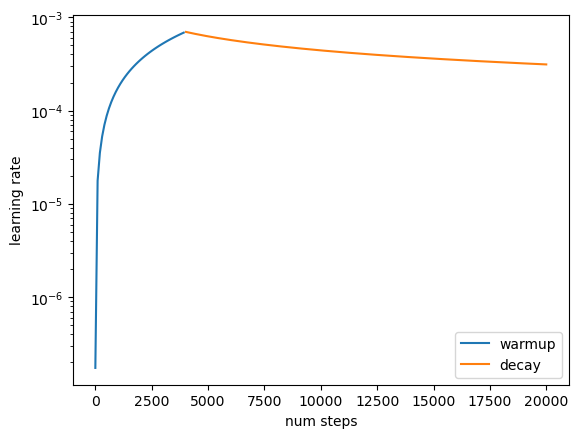

In [133]:
n_epoch = np.linspace(1, 20000, 200)
x = n_epoch[n_epoch <= 4000]
plt.plot(x, 512**-0.5 * x * 4000**-1.5, label="warmup")
x = n_epoch[n_epoch > 4000]
plt.plot(x, 512**-0.5 * x**-0.5, label="decay")
plt.xlabel("num steps")
plt.ylabel("learning rate")
plt.yscale("log")
plt.legend()
plt.show()

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=512**-0.5, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda nstep: min((nstep + 1) ** -0.5, (nstep + 1) * 4000 ** -1.5))
loss_fn = nn.CrossEntropyLoss() # could add label smoothing
run(dataloader, model, loss_fn, optimizer, scheduler)

Epoch 1
-------------------------------
Accuracy: 75.6%, Avg loss: 7.648376  [   64/45088]
Accuracy: 76.0%, Avg loss: 7.544426  [ 6464/45088]
Accuracy: 75.1%, Avg loss: 7.600710  [12864/45088]
Accuracy: 79.3%, Avg loss: 6.293508  [19264/45088]
Accuracy: 82.0%, Avg loss: 5.373775  [25664/45088]


KeyboardInterrupt: 

### Free Up Memory

In [ ]:
def free_memory(*args):
    for name in args:
        try:
            arg = globals()[name]
            arg.to("cpu")
            del arg
        except KeyError:
            pass
    gc.collect()
    torch.cuda.empty_cache()
    print(torch.cuda.memory_summary())


free_memory("model")

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1656 MiB |  12872 MiB |  45943 GiB |  45941 GiB |
|       from large pool |   1619 MiB |  12777 MiB |  45789 GiB |  45787 GiB |
|       from small pool |     37 MiB |    147 MiB |    154 GiB |    154 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   1656 MiB |  12872 MiB |  45943 GiB |  45941 GiB |
|       from large pool |   1619 MiB |  12777 MiB |  45789 GiB |